<a href="https://colab.research.google.com/github/khalid-shaik/Titanic-Survival-Prediction/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary libraries

In [82]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Load the dataset

In [83]:

data = pd.read_csv("/content/tested.csv")
data.columns = data.columns.str.strip()

In [84]:
# Display the first few rows
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [85]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Check for missing values

In [86]:

data.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1


In [87]:
# Drop 'Cabin' column due to too many missing values
if 'Cabin' in data.columns:
    data.drop('Cabin', axis=1, inplace=True)

# Fill missing 'Age' with median based on 'Pclass'
if 'Age' in data.columns:
    data['Age'] = data.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# Drop rows with missing 'Embarked'
if 'Embarked' in data.columns:
    data.dropna(subset=['Embarked'], inplace=True)


In [88]:
# Drop unnecessary columns if they exist
columns_to_drop = ['Name', 'Ticket']
for col in columns_to_drop:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)


In [89]:
# Convert 'Sex' and 'Embarked' to dummy variables
if 'Sex' in data.columns:
    sex = pd.get_dummies(data['Sex'], drop_first=True)
    data.drop('Sex', axis=1, inplace=True)
    data = pd.concat([data, sex], axis=1)

In [90]:
if 'Embarked' in data.columns:
    embark = pd.get_dummies(data['Embarked'], drop_first=True)
    data.drop('Embarked', axis=1, inplace=True)
    data = pd.concat([data, embark], axis=1)


In [91]:
# Store PassengerId separately for final submission
passenger_ids = data['PassengerId']
data.drop('PassengerId', axis=1, inplace=True)

In [92]:
# Define X (features) and y (target variable)
X = data.drop('Survived', axis=1)
y = data['Survived']


#Training & Tesing

In [93]:

# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [94]:
# Fill any remaining NaN values with median or mode
data.fillna(data.median(numeric_only=True), inplace=True)


In [96]:
print(X_train.isnull().sum())


Pclass    0
Age       0
SibSp     0
Parch     0
Fare      1
male      0
Q         0
S         0
dtype: int64


In [97]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)


In [98]:
print(X_train.isnull().sum().sum())  # Should return 0
print(X_test.isnull().sum().sum())   # Should return 0


0
0


#Model Fitiitng

In [99]:
from sklearn.linear_model import LogisticRegression

# Create and train the Logistic Regression model
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)

print("Model trained successfully!")


Model trained successfully!


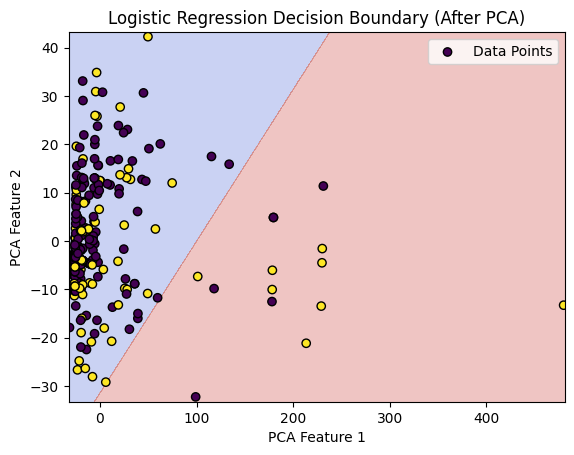

In [130]:
from sklearn.decomposition import PCA

# Reduce to 2 features using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Fit logistic regression again with 2 features
logmodel_pca = LogisticRegression(max_iter=1000)
logmodel_pca.fit(X_train_pca, y_train)

# Create meshgrid for plotting
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the meshgrid
Z = logmodel_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', label='Data Points')
plt.title('Logistic Regression Decision Boundary (After PCA)')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


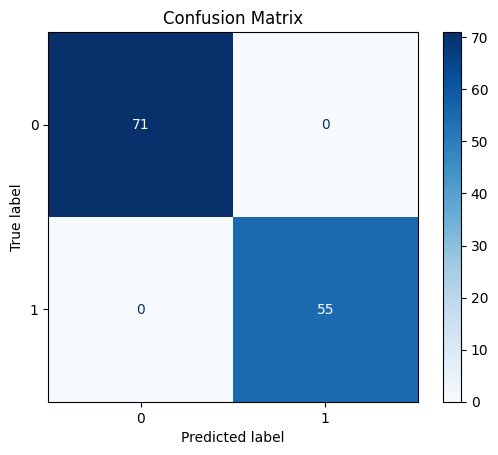

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred = logmodel.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logmodel.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


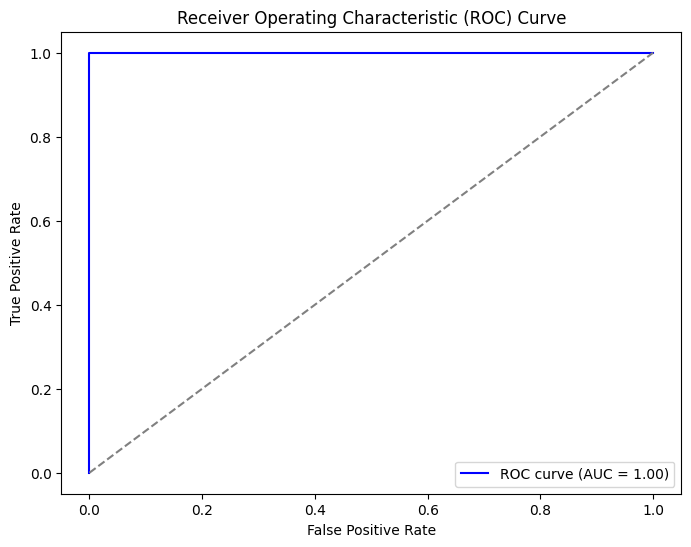

In [132]:
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities
y_prob = logmodel.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


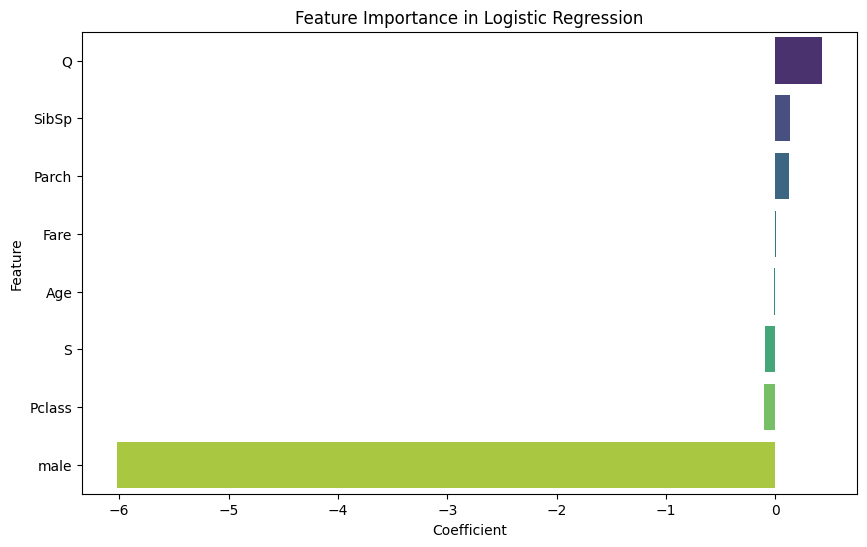

In [134]:
# Get feature importance from coefficients
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': logmodel.coef_[0]})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Plot feature importance with corrected syntax
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, hue='Feature', legend=False, palette='viridis')
plt.title('Feature Importance in Logistic Regression')
plt.show()


In [100]:
# Make predictions
predictions = logmodel.predict(X_test)


In [101]:
from sklearn.metrics import accuracy_score

# Check accuracy
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy: {accuracy * 100:.2f}%")


 Model Accuracy: 100.00%


In [102]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[71  0]
 [ 0 55]]


In [103]:
# Impute Fare column with median
X['Fare'].fillna(X['Fare'].median(), inplace=True)


<ipython-input-103-14f5fee87b22>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Fare'].fillna(X['Fare'].median(), inplace=True)


In [104]:
print(X.isnull().sum())


Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
male      0
Q         0
S         0
dtype: int64


Check Model with Cross-Validation:


In [105]:
# fit to model
logmodel.fit(X_train, y_train)

# Predict on Test Data
predictions = logmodel.predict(X_test)



In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
print(f" Accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%")

# Confusion Matrix
print(" Confusion Matrix:\n", confusion_matrix(y_test, predictions))

# Classification Report
print(" \nClassification Report:\n", classification_report(y_test, predictions))


 Accuracy: 100.00%
 Confusion Matrix:
 [[71  0]
 [ 0 55]]
 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        55

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [107]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(logmodel, X, y, cv=5)
print(f" Cross-Validation Scores: {cv_scores}")
print(f" Average CV Score: {cv_scores.mean() * 100:.2f}%")


 Cross-Validation Scores: [1. 1. 1. 1. 1.]
 Average CV Score: 100.00%


#Exploratory Data Analysis

In [108]:
data.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q',
       'S'],
      dtype='object')

Age Distribution of Survived vs Not Survived

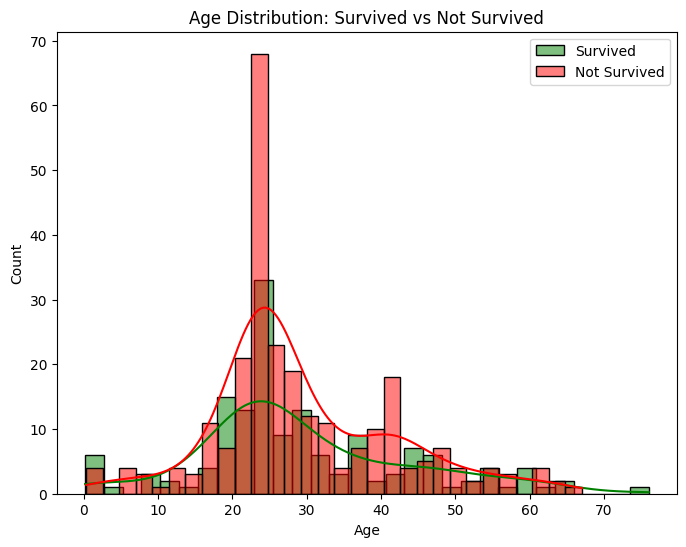

In [110]:
# Plot age distribution: Survived_Predicted vs Not Survived
plt.figure(figsize=(8, 6))
sns.histplot(data[data['Survived'] == 1]['Age'].dropna(), bins=30, label='Survived', color='green', kde=True)
sns.histplot(data[data['Survived'] == 0]['Age'].dropna(), bins=30, label='Not Survived', color='red', kde=True)
plt.title('Age Distribution: Survived vs Not Survived')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()


Survival Count Plot

<ipython-input-111-8ebc55f9b3a8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=data, palette='Set2')


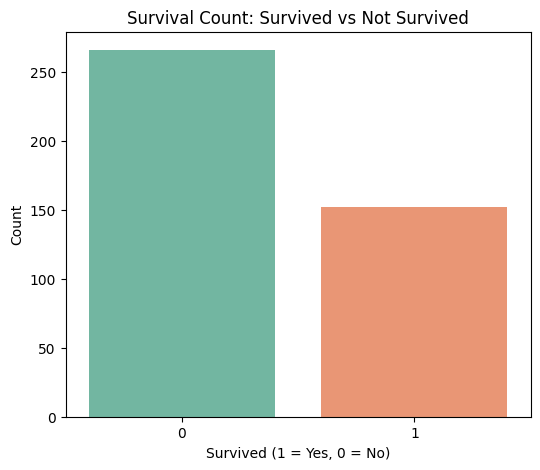

In [111]:
# Count plot for Survived_Predicted
plt.figure(figsize=(6, 5))
sns.countplot(x='Survived', data=data, palette='Set2')
plt.title('Survival Count: Survived vs Not Survived')
plt.xlabel('Survived (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()


Survival by Pclass

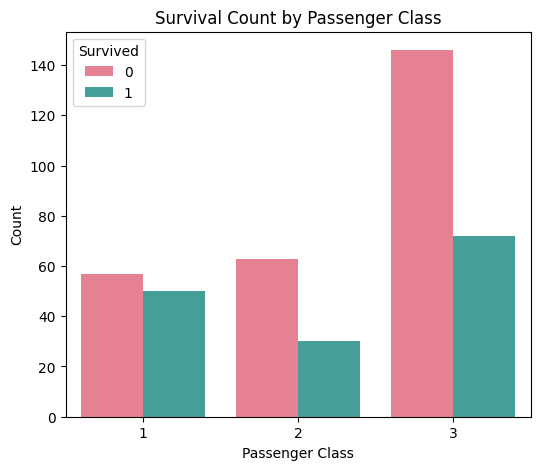

In [112]:
# Survival count by Passenger Class
plt.figure(figsize=(6, 5))
sns.countplot(x='Pclass', hue='Survived', data=data, palette='husl')
plt.title('Survival Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.show()


 Fare Distribution: Survived vs Not Survived

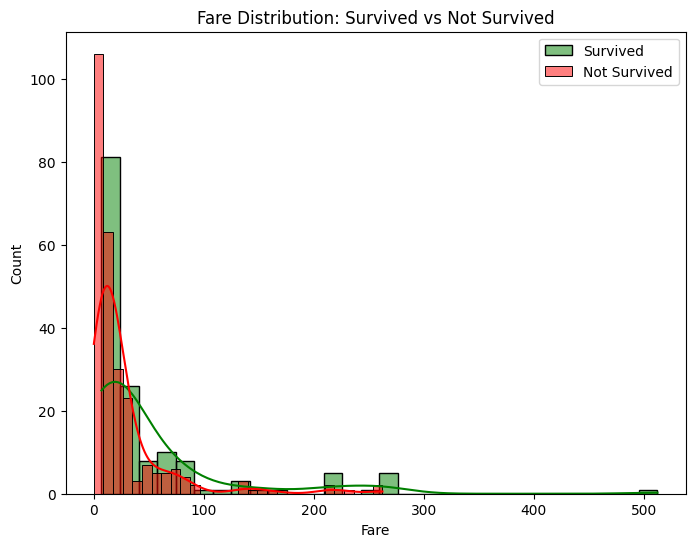

In [113]:
# Plot Fare distribution by Survived_Predicted
plt.figure(figsize=(8, 6))
sns.histplot(data[data['Survived'] == 1]['Fare'].dropna(), bins=30, label='Survived', color='green', kde=True)
sns.histplot(data[data['Survived'] == 0]['Fare'].dropna(), bins=30, label='Not Survived', color='red', kde=True)
plt.title('Fare Distribution: Survived vs Not Survived')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.legend()
plt.show()


Survival by Gender


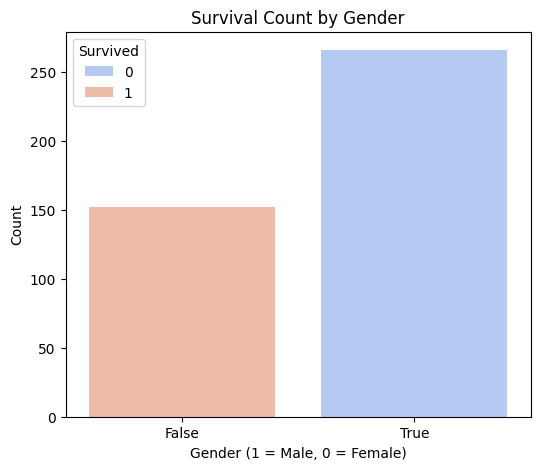

In [114]:
# Survival count by Gender
plt.figure(figsize=(6, 5))
sns.countplot(x='male', hue='Survived', data=data, palette='coolwarm')
plt.title('Survival Count by Gender')
plt.xlabel('Gender (1 = Male, 0 = Female)')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.show()


Survival by Embarked Location

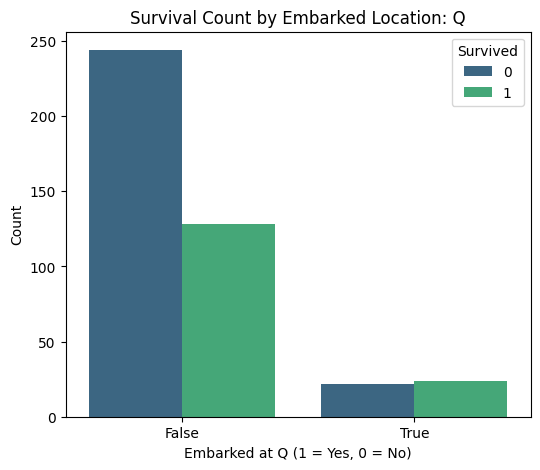

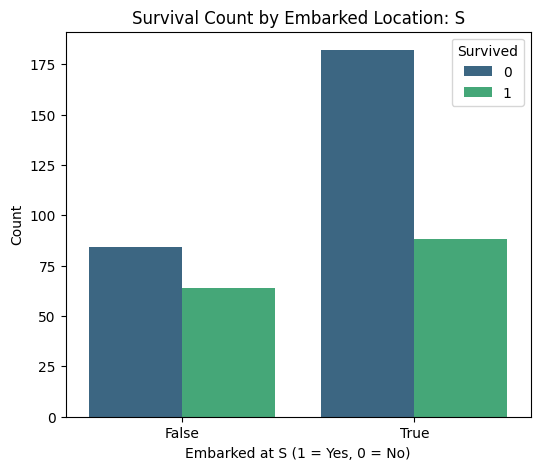

In [115]:
# Survival count by Embarked location
embarked_cols = ['Q', 'S']

for col in embarked_cols:
    plt.figure(figsize=(6, 5))
    sns.countplot(x=col, hue='Survived', data=data, palette='viridis')
    plt.title(f'Survival Count by Embarked Location: {col}')
    plt.xlabel(f'Embarked at {col} (1 = Yes, 0 = No)')
    plt.ylabel('Count')
    plt.legend(title='Survived')
    plt.show()


Survival Distribution

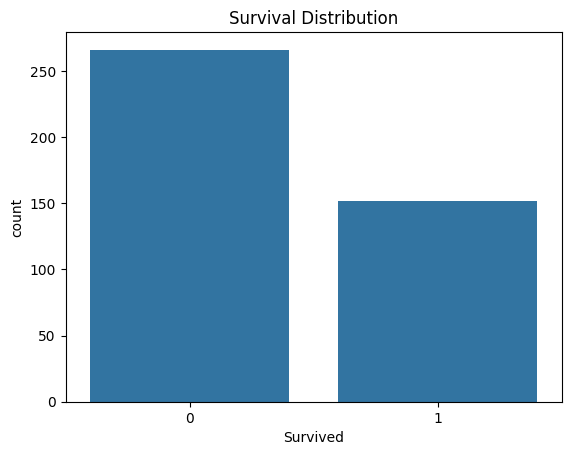

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot survival count
sns.countplot(x='Survived', data=data)
plt.title('Survival Distribution')
plt.show()



Correlation Heatmap

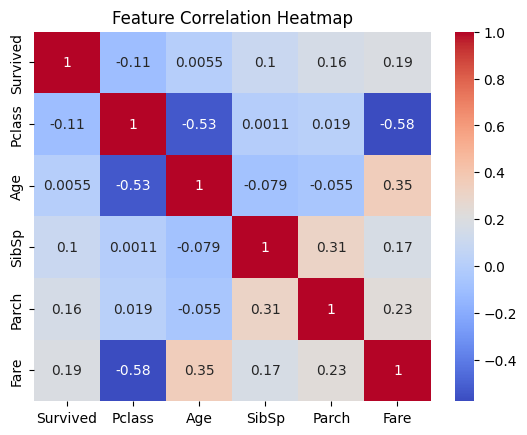

In [117]:
# Drop non-numeric columns
data_numeric = data.select_dtypes(include=['number'])

# Create heatmap
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


Pair Plot for Important Features

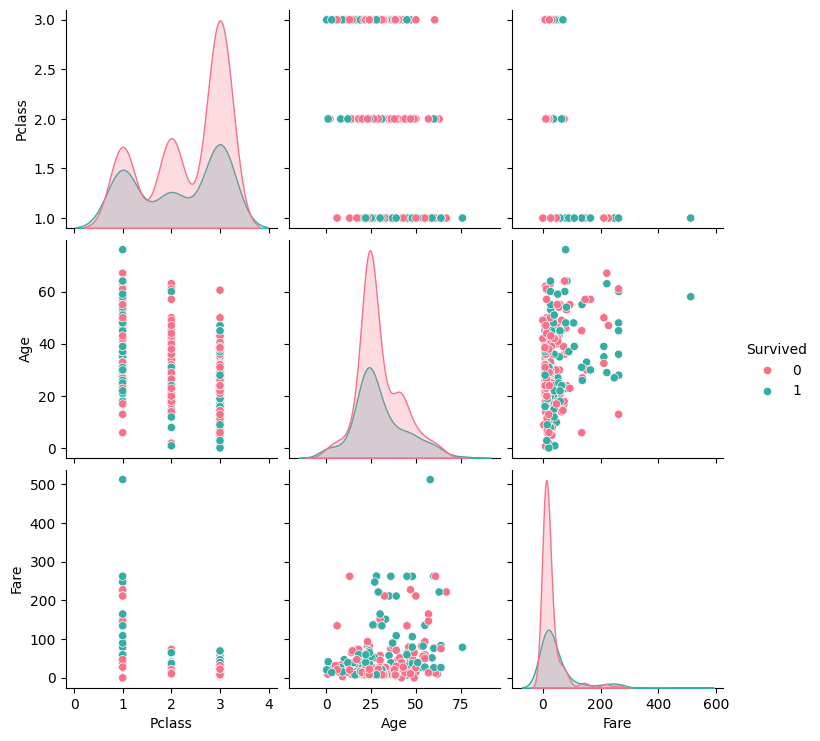

In [119]:
# Pair plot to visualize feature relationships
sns.pairplot(data[['Pclass', 'Age', 'Fare', 'Survived']], hue='Survived', palette='husl')
plt.show()


#Hyperparameter Tuning

In [120]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 2000]  # Increase iterations
}


In [121]:
model = LogisticRegression(solver='liblinear', C=1, max_iter=2000)


In [122]:
from sklearn.linear_model import LogisticRegression

# Best parameters from GridSearchCV
model = LogisticRegression(solver='liblinear', C=1, max_iter=2000)

# Model to train
model.fit(X_train, y_train)

# Predicting
predictions = model.predict(X_test)

#  if Survived  'Yes' or'No'
predicted_labels = ['Yes' if p == 1 else 'No' for p in predictions]
print(predicted_labels)


['No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes']


#Pickling & predictions

In [123]:
import joblib
# Save Model
joblib.dump(logmodel, 'titanic_model.pkl')
# Load Model
loaded_model = joblib.load('titanic_model.pkl')


In [124]:
import pickle

# Save the trained model
with open('titanic_model.pkl', 'wb') as file:
    pickle.dump(logmodel, file)


In [125]:
import pandas as pd
import pickle

# Load the trained model correctly
with open('titanic_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Load new data
data = pd.read_csv('tested.csv')

# Drop unnecessary columns
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True, errors='ignore')

# Encode categorical variables
data['Sex'] = data['Sex'].map({'male': 1, 'female': 0})
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

# Handle missing values
data.fillna(data.mean(), inplace=True)

# Ensure feature columns match with training data
expected_cols = model.feature_names_in_
data = data.reindex(columns=expected_cols, fill_value=0)

# Predict survival
predictions = model.predict(data)

# Add predictions to original data
data['Survived_Predicted'] = predictions

# Save predictions to a new CSV
data.to_csv('predicted_results.csv', index=False)

print(" Prediction complete! Check 'predicted_results.csv' for results.")


 Prediction complete! Check 'predicted_results.csv' for results.


In [126]:
from google.colab import files

# Download the predicted_results.csv file
files.download('predicted_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
import pandas as pd

# Load the predictions to display
predicted_results = pd.read_csv('predicted_results.csv')

# Show the first 10 rows of predictions
print(predicted_results.head(10))


   Pclass   Age  SibSp  Parch     Fare  male  Q  S  Survived_Predicted
0       3  34.5      0      0   7.8292     0  0  0                   1
1       3  47.0      1      0   7.0000     0  0  0                   1
2       2  62.0      0      0   9.6875     0  0  0                   1
3       3  27.0      0      0   8.6625     0  0  0                   1
4       3  22.0      1      1  12.2875     0  0  0                   1
5       3  14.0      0      0   9.2250     0  0  0                   1
6       3  30.0      0      0   7.6292     0  0  0                   1
7       2  26.0      1      1  29.0000     0  0  0                   1
8       3  18.0      0      0   7.2292     0  0  0                   1
9       3  21.0      2      0  24.1500     0  0  0                   1


The Logistic Regression model demonstrated good predictive ability and provided meaningful insights into the factors influencing Titanic passenger survival. However, exploring advanced models could further enhance the prediction accuracy.